# PCA + Neural Network Classifier with MNIST


## Libraries

In [1]:
# libraries
using Flux              # the julia ml library
using Images            # image processing and machine vision for julia
using MLJ               # make_blobs, rmse, confmat, f1score, coerce
using MLJFlux           # NeuralNetworkClassifier, CUDALibs
using MLDataUtils       # label, nlabel, labelfreq
using MLDatasets        # mnist

#using LinearAlgebra     # pinv pseudo-inverse matrix
#using Metrics           # r2-score
using Random
using StatsBase         # standardize (normalization)
#using Distributions

using Plots; gr()
#using StatsPlots
using Printf

#using CSV
using DataFrames


## Functions

In [75]:
# lib functions
image2Vector(M) = vec(Float64.(M))

function batchImage2Vector(imagesArray3D)
    h, v, N = size(imagesArray3D)
    vectorOfImageVectors = [ image2Vector( imagesArray3D[:, :, i] ) for i in 1:N]
end

function batchImage2Matrix(imagesArray3D)
    vectorOfImageVectors = batchImage2Vector(imagesArray3D)
    M = reduce(hcat, vectorOfImageVectors)
    M'
end

function batchImage2DF(imagesArray3D)
    vectorOfImageVectors = batchImage2Vector(imagesArray3D)
    M = reduce(hcat, vectorOfImageVectors)
    DataFrame(M', :auto)
end


batchImage2DF (generic function with 1 method)

In [76]:
# metrics
function printMetrics(ŷ, y)
    display(confmat(ŷ, y))
    println("accuracy: ", round(accuracy(ŷ, y); digits=3))
    println("f1-score: ", round(multiclass_f1score(ŷ, y); digits=3))
end


printMetrics (generic function with 1 method)

## Loading the data

,,,,

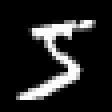
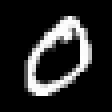
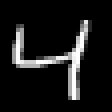
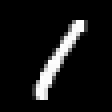
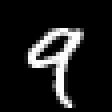

1×5 adjoint(::Vector{Int64}) with eltype Int64:
 5  0  4  1  9

In [77]:
# load mnist from MLDatasets
trainX_original,      trainY_original      = MNIST.traindata()
validationX_original, validationY_original = MNIST.testdata();

display([MNIST.convert2image(MNIST.traintensor(i)) for i in 1:5])
trainY_original[1:5]'

In [78]:
# split trainset, testset, validation set
Random.seed!(1)
(trainX, trainY), (testX, testY) = stratifiedobs((trainX_original, trainY_original), p = 0.7)
validationX = copy(validationX_original); validationY = copy(validationY_original)

size(trainX), size(testX), size(validationX)

((28, 28, 42001), (28, 28, 17999), (28, 28, 10000))

## Data preprocessing

Flux primarily works with matrices and vectors

In [111]:
function preprocessing(X, y)
    newX = batchImage2DF(X)
    new_y = coerce(y, OrderedFactor)
    
    return (newX, new_y)
end

X, y = preprocessing(trainX, trainY);

In [112]:
X

,x1,x2,x3,x4,x5,x6,x7,x8,x9
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [113]:
typeof(X)

DataFrame

In [114]:
scitype(y)

AbstractVector{OrderedFactor{10}} (alias for AbstractArray{OrderedFactor{10}, 1})

In [115]:
# reduce predictors
PCA = @load PCA pkg=MultivariateStats verbosity=0
reducer = PCA(pratio = 0.95)

PCA(
    maxoutdim = 0,
    method = :auto,
    pratio = 0.95,
    mean = nothing)

In [116]:
# standardize predictors
std = Standardizer();

In [117]:
# pipeline preprocessing models
reducerStdModel = @pipeline reducer std

Pipeline350(
    pca = PCA(
            maxoutdim = 0,
            method = :auto,
            pratio = 0.95,
            mean = nothing),
    standardizer = Standardizer(
            features = Symbol[],
            ignore = false,
            ordered_factor = false,
            count = false))

In [119]:
mach = MLJ.machine(reducerStdModel, X) |> fit!


┌ Info: Training Machine{Pipeline350,…}.
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/pCiRR/src/machines.jl:464
┌ Info: Training Machine{PCA,…}.
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/pCiRR/src/machines.jl:464
┌ Info: Training Machine{Standardizer,…}.
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/pCiRR/src/machines.jl:464


Machine{Pipeline350,…} trained 1 time; caches data
  model: Pipeline350
  args: 
    1:	Source @637 ⏎ `Table{AbstractVector{Continuous}}`


In [120]:
# MLJ.predict(mach, X)   # for SUPERVISED models
X_til = MLJ.transform(mach, X)   # for UNsupervised models
first(X_til, 5)


,x1,x2,x3,x4,x5,x6,x7,x8
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.02553,0.364736,-0.304525,-0.985644,1.25581,0.654737,0.517962,2.86921
2,1.26633,-0.2766,-1.84139,0.46436,0.0501056,0.141543,0.672341,-0.192563
3,1.5935,-0.231705,-1.91622,0.7771,2.09254,-1.47511,-1.23363,1.16234
4,0.0313316,-0.864218,-0.954639,1.03453,1.16941,0.83675,2.1645,-0.26777
5,-0.824789,0.471452,0.222981,-0.530035,-0.209061,1.48011,-1.07067,0.662548


### Exemplo preliminar DNN

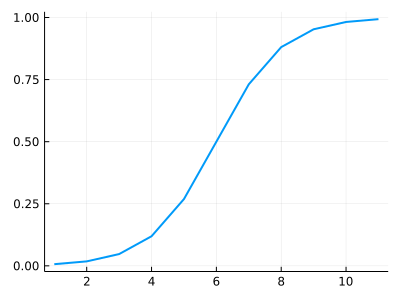

In [121]:
# built-in sigmoid function
plot(σ.(-5:5), size=(400,300), linewidth=2, legend=false)

In [159]:
N, d = size(X_til)
model = Dense(d, 9, σ)

Dense(154, 9, σ)    # 1_395 parameters

In [165]:
model.weight

9×154 Matrix{Float32}:
  0.0222149  -0.0593532  -0.181666   …  -0.123737    -0.149022    0.0972907
 -0.16267    -0.133467   -0.048476       0.00542348   0.143198   -0.0269723
  0.052691   -0.139339    0.132297      -0.0711848   -0.157632   -0.0271064
 -0.171137   -0.0057999   0.12815        0.162015    -0.0278823  -0.154353
  0.0922938  -0.147933    0.137583      -0.071705    -0.17996    -0.0182612
 -0.0264148  -0.148549   -0.0422901  …  -0.102832     0.112628    0.0704227
  0.113023   -0.13526     0.0189532     -0.13652      0.0341689   0.177747
  0.0852661   0.115782    0.0356976     -0.0337282   -0.179284   -0.0458618
  0.0770094  -0.0987856   0.155788      -0.113227    -0.0689776  -0.11275

In [166]:
model.bias

9-element Vector{Float32}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [167]:
x1 = X_til[1,:] |> Array
model(x1)

9-element Vector{Float64}:
 0.1069152380194064
 0.09819904272813929
 0.6196516524546882
 0.3130901944983301
 0.45980197000265377
 0.7882733932090784
 0.2405895056315691
 0.5639437908126231
 0.3485671751831652